# Methods and Results

In [1]:
# import the libraries used for analysis

library(GGally)
library(tidyverse)
library(infer)
library(cowplot)
library(broom)

Loading required package: ggplot2

Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2

-- Attaching packages --------------------------------------- tidyverse 1.3.2 --
v tibble  3.1.8      v dplyr   1.0.10
v tidyr   1.2.1      v stringr 1.4.1 
v readr   2.1.3      v forcats 0.5.2 
v purrr   0.3.5      
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()


In [3]:
order <- c("low","high")

dataset <- read_csv('../data/forestfires.csv') %>%
  select(wind, area) %>%
  mutate(wind = as.numeric(wind), area = as.numeric(area)) %>% #Wrangling data and selecting columns to be used in prediction
  filter(!is.na(wind) | !is.na(area)) %>%
  mutate(
    category=cut(wind, breaks=quantile(wind,c(0,1/2,1)), labels=order,include.lowest = TRUE),
    area_log10 = log10(1+ area)
  )

head(dataset)

Rows: 517 Columns: 13
-- Column specification --------------------------------------------------------
Delimiter: ","
chr  (2): month, day
dbl (11): X, Y, FFMC, DMC, DC, ISI, temp, RH, wind, rain, area

i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.


wind,area,category,area_log10
<dbl>,<dbl>,<fct>,<dbl>
6.7,0,high,0
0.9,0,low,0
1.3,0,low,0
4.0,0,low,0
1.8,0,low,0
5.4,0,high,0


# A tibble: 1 x 2
  lower_ci upper_ci
     <dbl>    <dbl>
1    -11.7     10.5


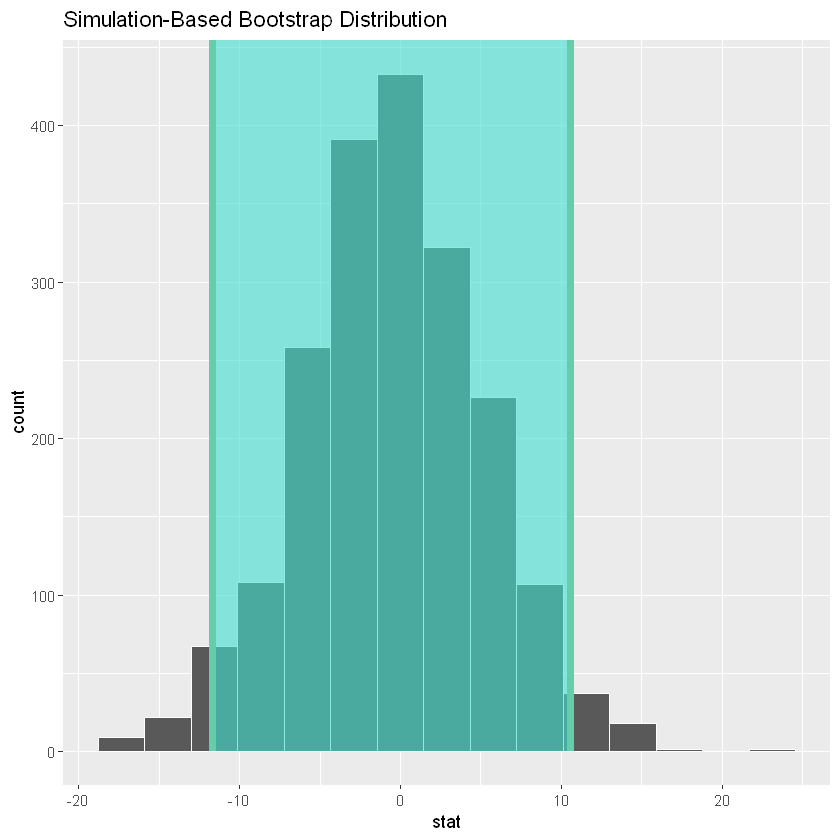

In [4]:
bootstrap_dist_data_infer <- dataset %>%
	specify(formula = area~category) %>%
	generate(type = "bootstrap", reps = 2000) %>%
	calculate(stat = "diff in means", order = order) 
	
percentile_ci <- bootstrap_dist_data_infer	%>%
	get_ci(type = "percentile", level = 0.95)

print(percentile_ci)
bootstrap_dist_data_infer	%>%	visualize() +
	shade_confidence_interval(endpoints = percentile_ci)

# A tibble: 1 x 2
  lower_ci upper_ci
     <dbl>    <dbl>
1    -16.4     12.1


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
"collapsing to unique 'x' values"
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
"collapsing to unique 'x' values"
Warning message:
"Please be cautious in reporting a p-value of 0. This result is an approximation based on the number of `reps` chosen in the `generate()` step. See `?get_p_value()` for more information."


p_value
<dbl>
0


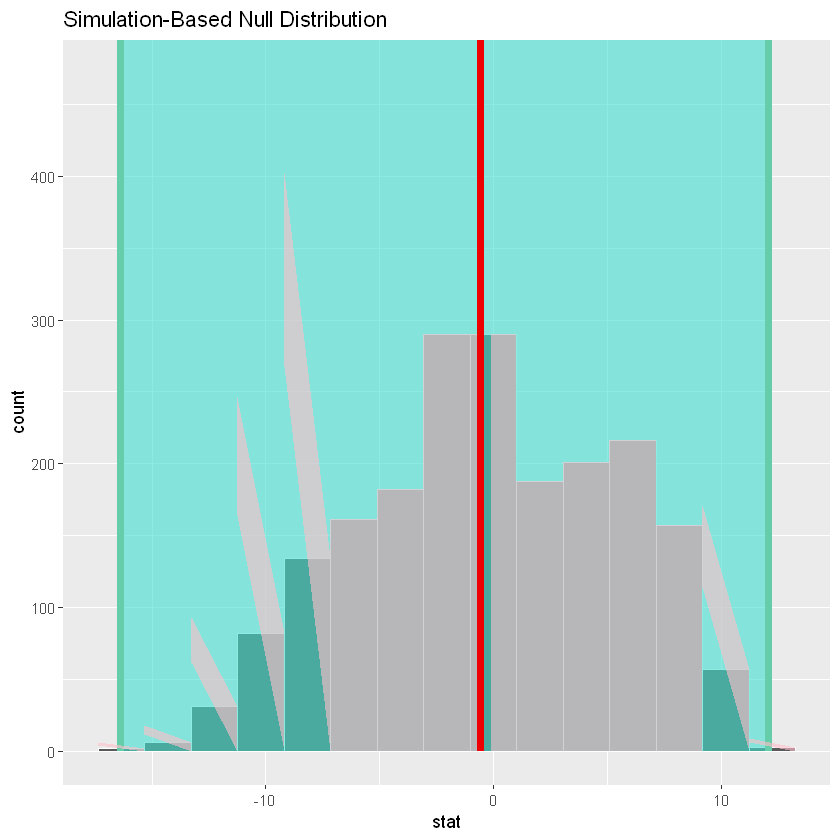

In [5]:
level <- 0.9999

null_distribution_mean <- dataset %>%
  specify(formula = area~category) %>% 
  hypothesize(null = "independence") %>% 
  generate(reps = 2000, type = "permute") %>% 
  calculate(stat = "diff in means", order = order)

percentile_ci_null <- null_distribution_mean	%>%
	get_ci(type = "percentile", level =level)

print(percentile_ci_null)

obs_diff_means <- dataset %>% 
  specify(formula = area~category) %>% 
  calculate(stat = "diff in means", order = order)

null_distribution_mean	%>%	visualize() +
	shade_confidence_interval(endpoints = percentile_ci_null) +
  shade_p_value(obs_stat = obs_diff_means, direction = "both")

dataset %>% 
  get_p_value(obs_stat = obs_diff_means, direction = "both")